# Baseline: Linear Interpolation

## Load Libraries

In [1]:
from util import *
from util.parser import *
from util.img_kit import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (60.0, 48.0) # set default size of plots

%load_ext autoreload
%autoreload 2

## Load Data

In [27]:
""" Load data """
img_folder = "data/moving-box/frames/moving-box-uniform/128x128"
# img_folder = "data/moving-box/frames/moving-two-box-uniform"
# img_folder = "data/kid-conversation"
# img_folder = "data/kid-swing"
imgs = [p[2] for p in walk(img_folder)][0]
imgs = list(filter(lambda x: not x.startswith("."), imgs))
prefix, postfix = imgs[0].split("-")[0], imgs[0].split(".")[1]
ffmpeg = imgs_in_folder("data/moving-box/frames/ffmpeg/128x128")
print("Total Images: {}".format(len(imgs)))
print("From:         {}".format(imgs[0]))
print("To:           {}".format(imgs[-1]))

Total Images: 15
From:         box-001.jpeg
To:           box-015.jpeg


## Set Parameters

In [28]:
gap = 1  # size of gap to interpolate

assert gap%2==1, "gap must be an odd number, so that we can get the ground-truth mid-image!"
assert gap>0, "gap must be positive!"
assert gap < len(imgs), "gap must be smaller than length of total images"

## Get Train Images and Ground Truth

In [29]:
base_index = parse_img_index(imgs[0])
to = parse_img_index(imgs[-1]) - (len(imgs)-1)%(gap + 1)
num_intervals = (to-base_index)//(gap + 1)

print("Select Range:  {} -> {} | {} Intervals".format(base_index, to, num_intervals))

Select Range:  1 -> 15 | 7 Intervals


In [30]:
def index_to_img(i):
    return "{}/{}-{}.{}".format(img_folder, prefix, "%03d"%(base_index + i), postfix)

In [49]:
x_index = [i*(gap+1) for i in range(num_intervals + 1)]
X = [misc.imread(index_to_img(i)) for i in x_index]    # training images
ffmpeg_mid = [ffmpeg[i] for i in x_index]
mid_index = [x + (gap+1)//2 for x in x_index[:-1]]
y = [misc.imread(index_to_img(i)) for i in mid_index]  # ground truth of images in betwen
print("Image shape: {}".format(X[0].shape))

Image shape: (128, 128, 3)


## Display Input

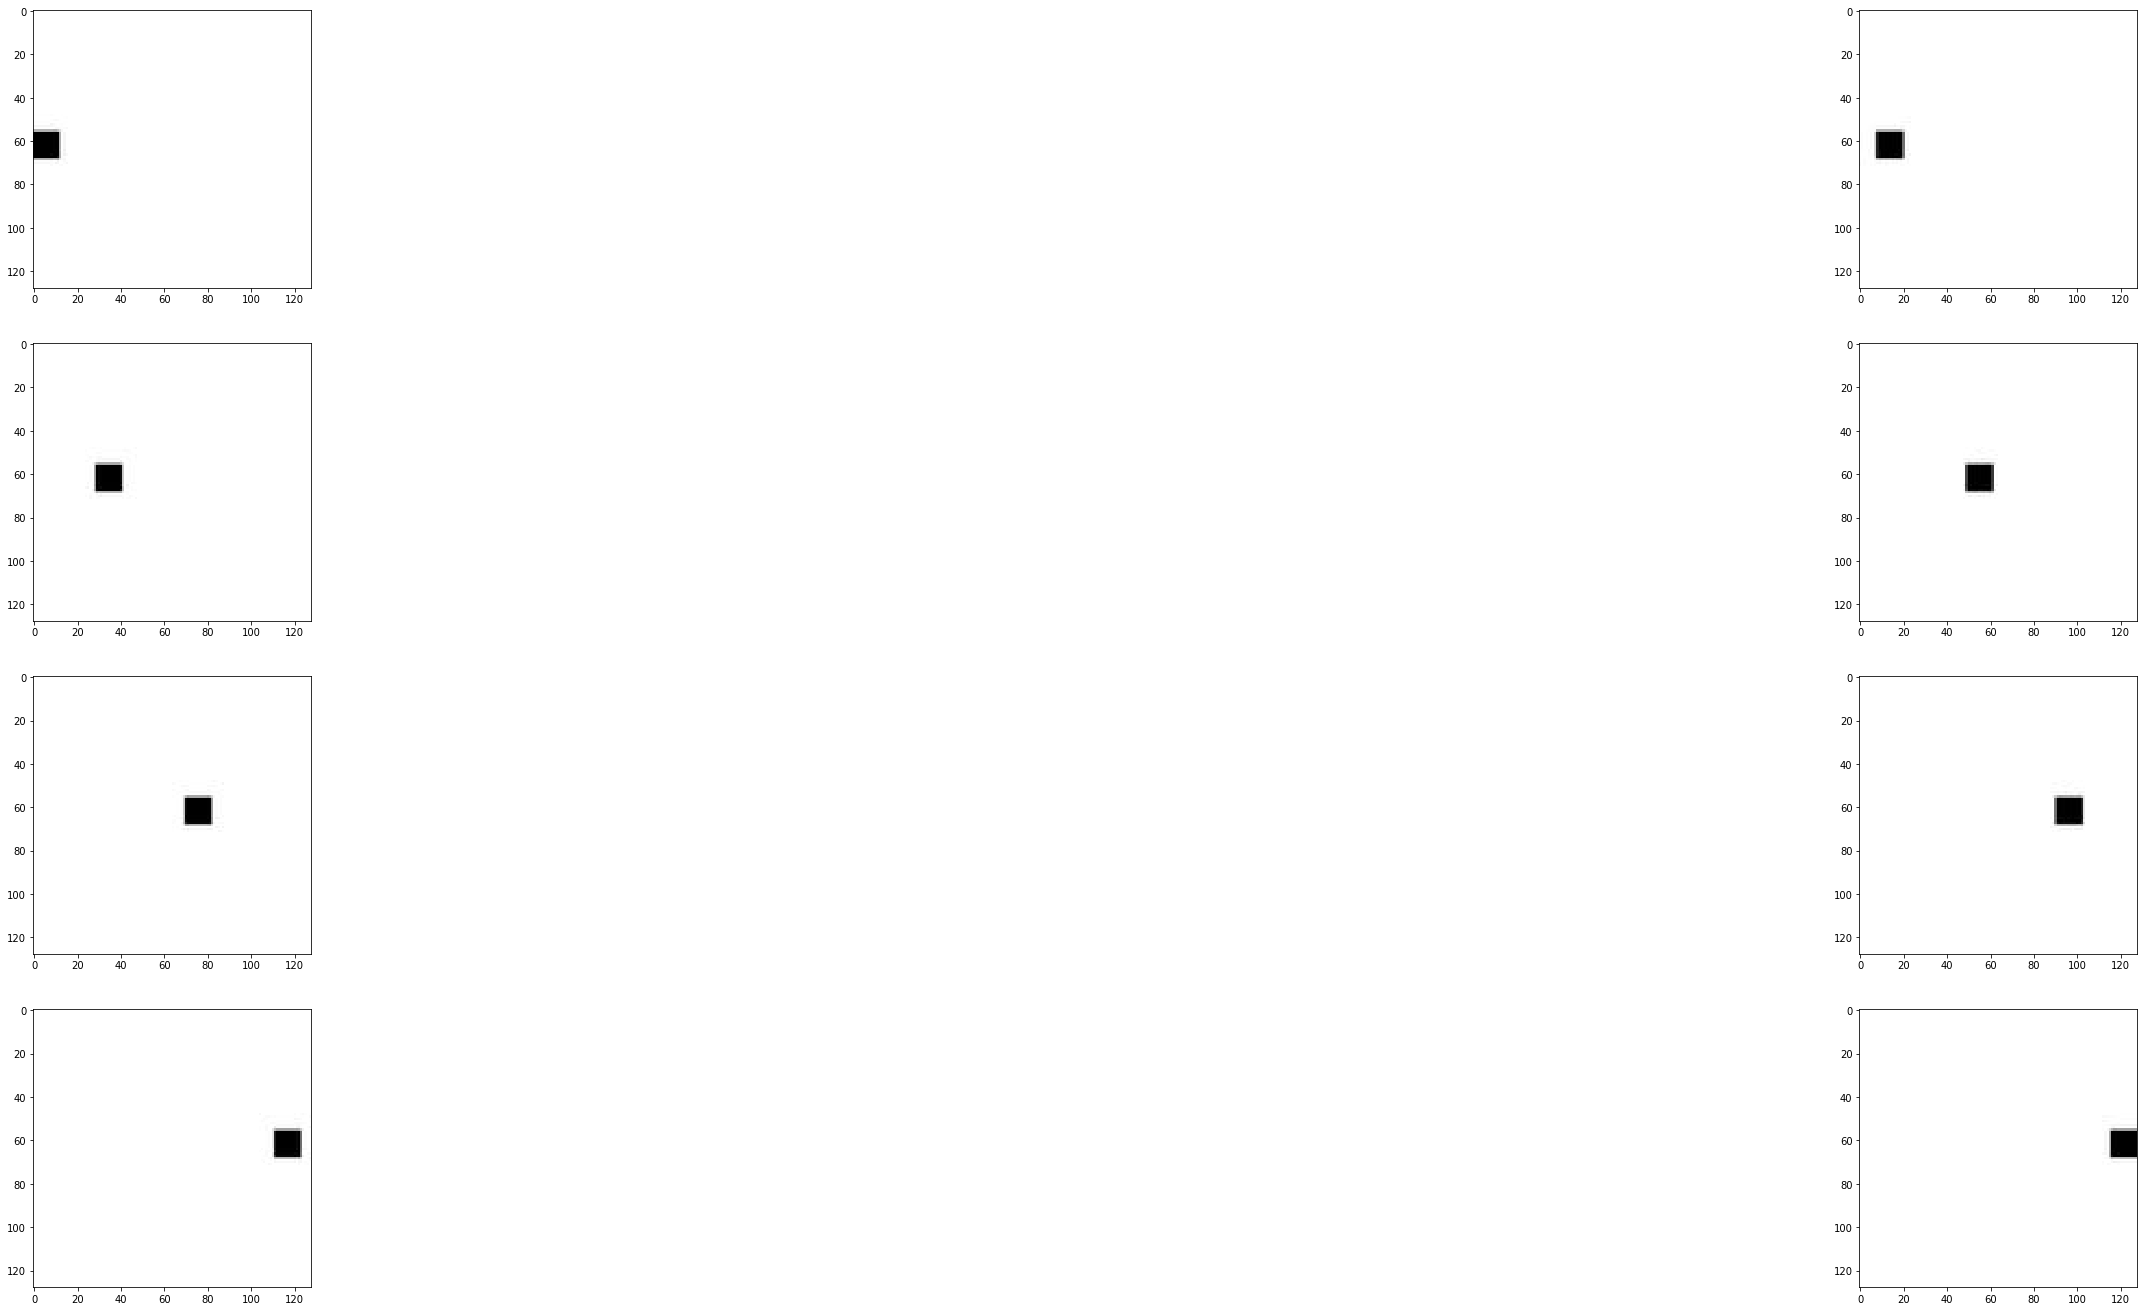

In [50]:
for i in range(len(X)):
    plt.subplot(num_intervals+1, 2, i+1)
    plt.imshow(X[i])

## Linear-interpolate Input Images

In [51]:
def avg_imges(x1, x2):
    return np.array([x1, x2]).mean(axis=0).astype('uint8')

In [52]:
interporlated = [avg_imges(X[i], X[i+1]) for i in range(len(X)-1)]

## Compare

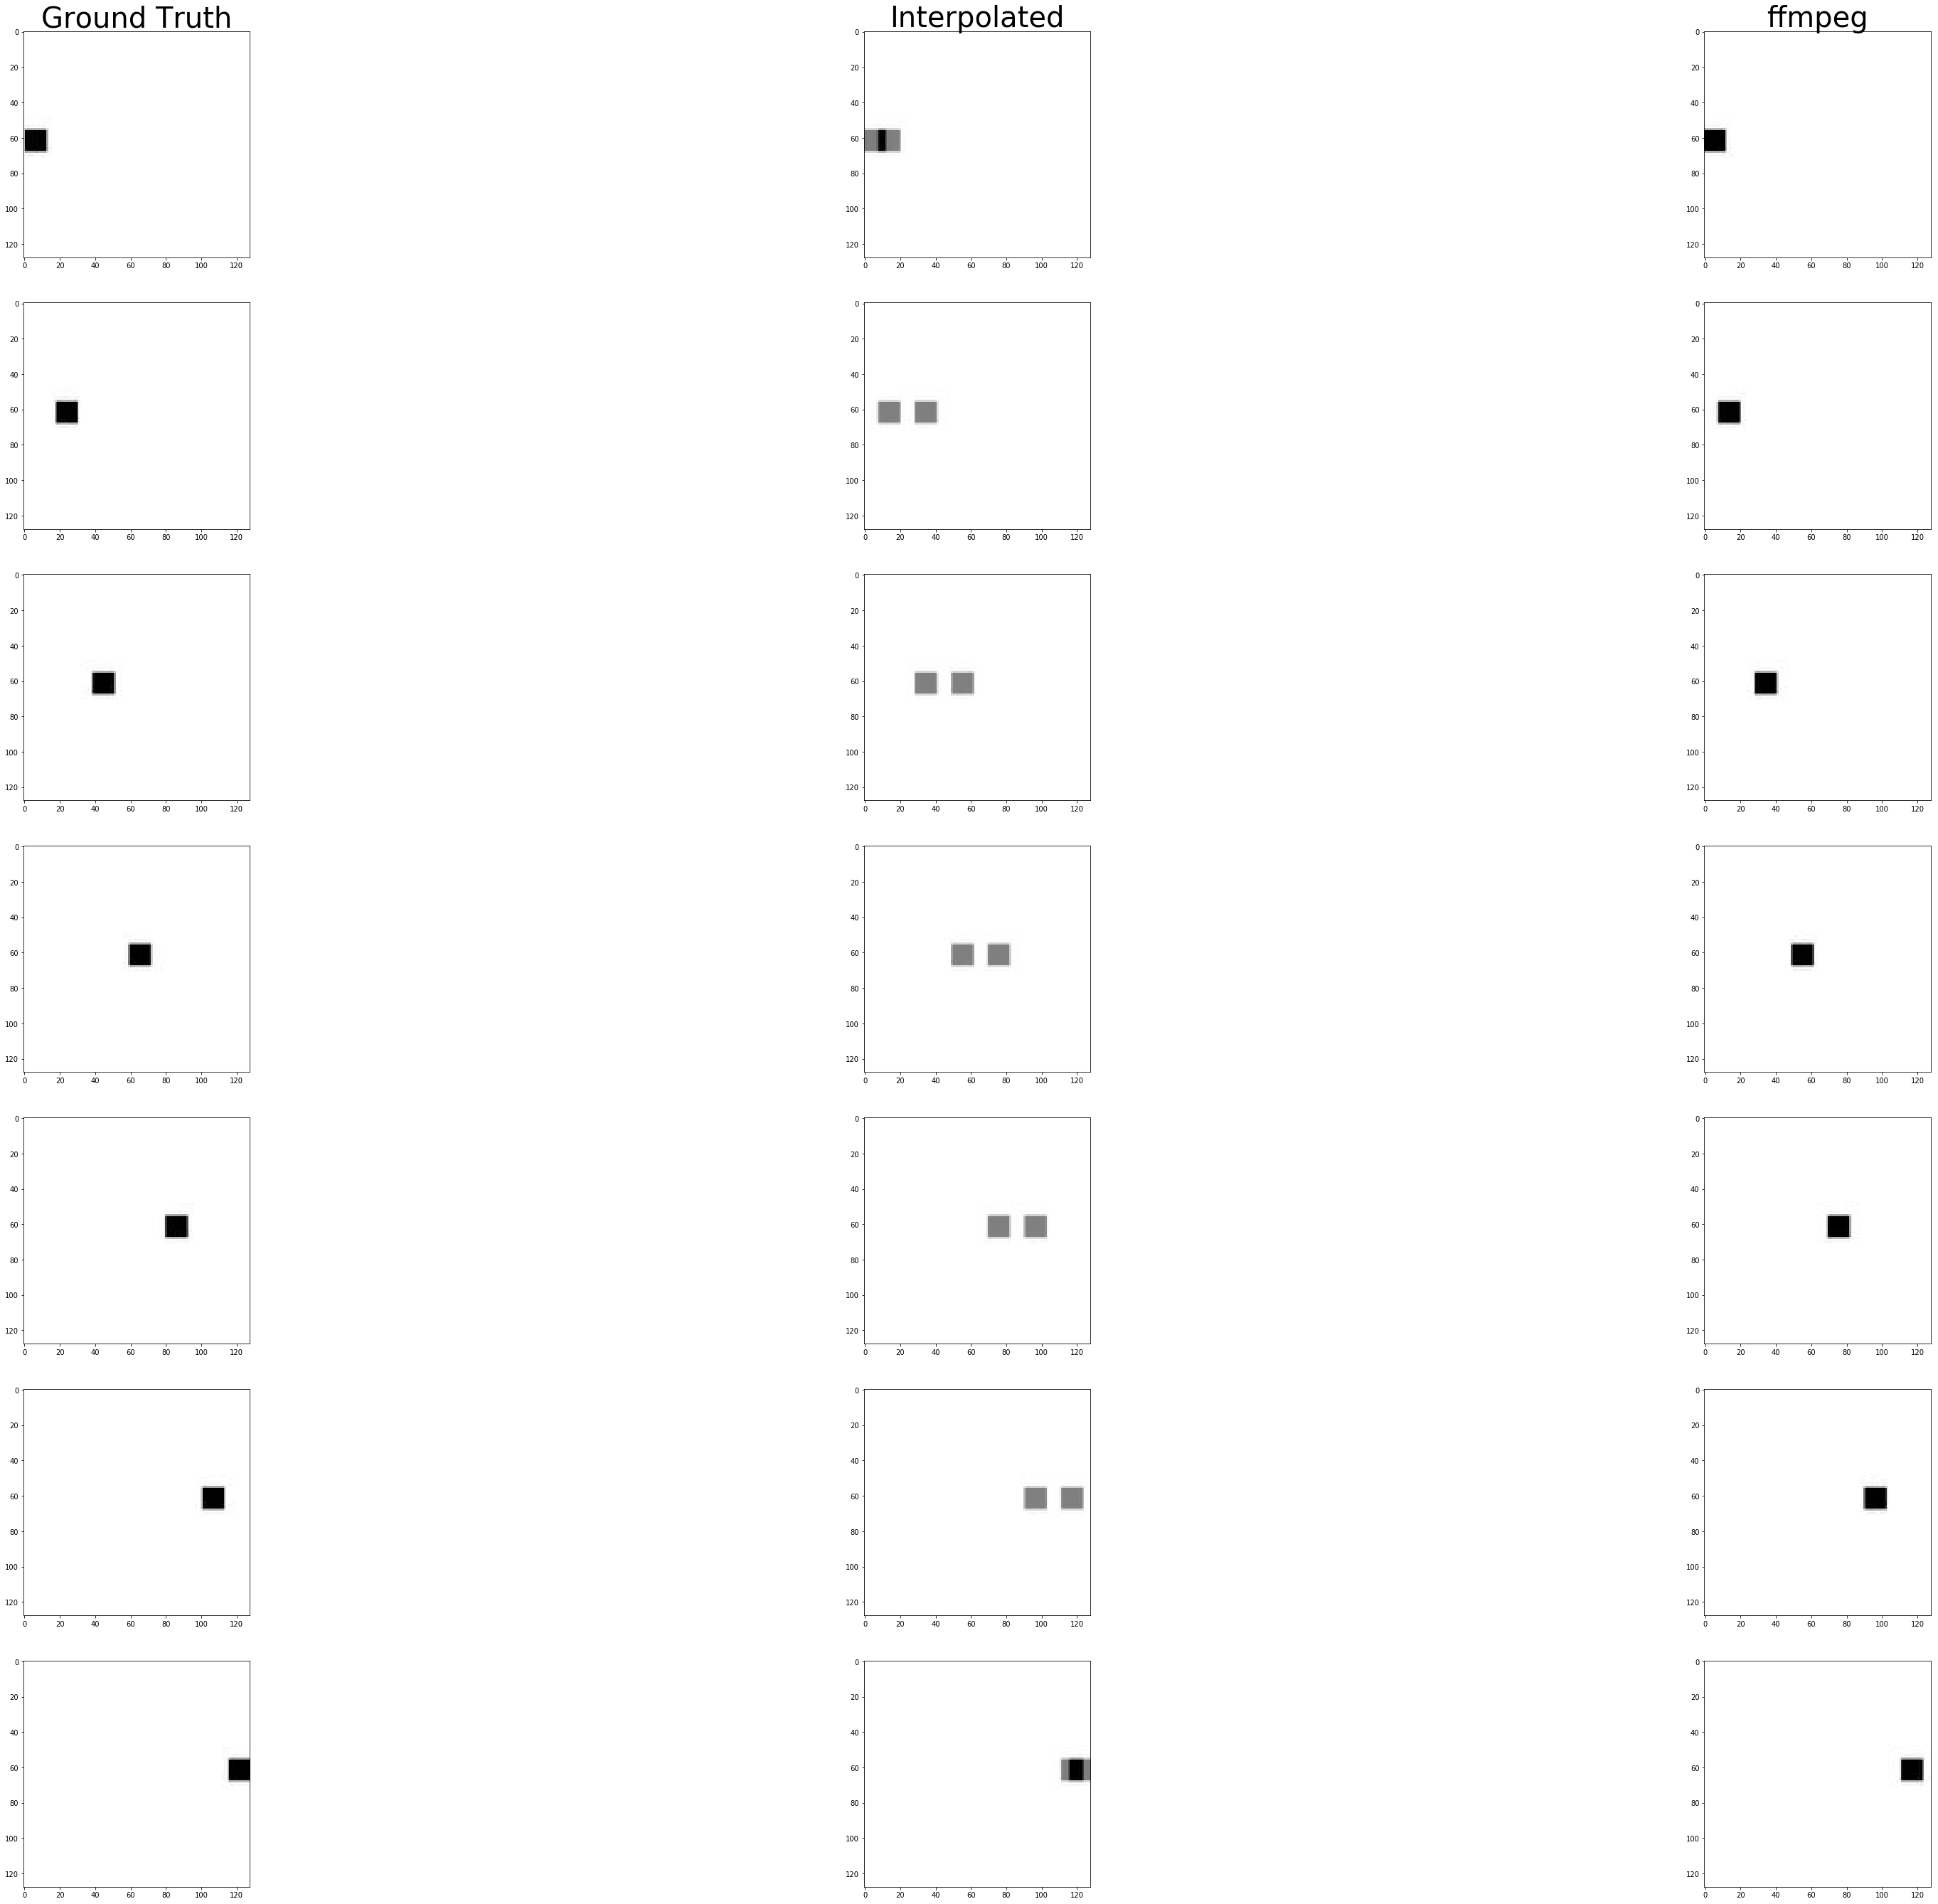

In [53]:
compare = list(zip(interporlated, y))
for i in range(num_intervals):
    infer, gd = compare[i]
    
    plt.subplot(num_intervals, 3, i*3 + 1)
    if i == 0: plt.title("Ground Truth", fontsize=40)
    plt.imshow(gd)
    
    plt.subplot(num_intervals, 3, i*3 + 2)
    if i == 0: plt.title("Interpolated", fontsize=40)
    plt.imshow(infer)
    
    plt.subplot(num_intervals, 3, i*3 + 3)
    if i == 0: plt.title("ffmpeg", fontsize=40)
    plt.imshow(ffmpeg_mid[i])


## GIF

#### Simuate video effect 

In [54]:
out_folder = "output/gif"
infer_output = os.path.join(out_folder, "interporlated.gif")
duration = 1
gd_output = os.path.join(out_folder, "ground_truth.gif")

infer_gif = gif.compile_frames_to_gif(merge(X, interporlated), infer_output,  duration=duration)
gd_gif = gif.compile_frames_to_gif(merge(X, y), gd_output, duration=duration)

print("GIF generated! \ninfer: {} \nground-truth: {}".format(infer_output, gd_output))

GIF generated! 
infer: output/gif/interporlated.gif 
ground-truth: output/gif/ground_truth.gif


In [55]:
def display_gif(fn, name, width=300):
    return display.HTML('<h3>{}</h3> <img src="{}", width={}>'.format(name, fn, width))

In [56]:
display_gif(infer_output, "Interporlation GIF")

In [57]:
display_gif(gd_output, "Ground Truth GIF")

### Observation
- Linear interporlation generates blurry video effect

## Loss

In [58]:
def get_loss(p1, p2):
    """
    pixel-wise L2 loss
    """
    return np.linalg.norm(p1-p2)

In [59]:
loss = np.mean([get_loss(*c) for c in compare])
ffmpeg_loss = np.mean([get_loss(y[i], ffmpeg[2*i+1]) for i in range(len(y))])
print("Loss: %.1f"%loss)
print("ffmpeg_loss: %.1f"%ffmpeg_loss)

Loss: 8445.6
ffmpeg_loss: 6509.9
